<a href="https://colab.research.google.com/github/MarahRamadan/Kaggle-competition-Cats-vs-Dogs/blob/master/Kaggle_competition_'Cats'_vs_'Dogs'_Convolution_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying 'Cats' vs 'Dogs' images using Convolution Neural Network(CNN) .
**The full dataset is taken from [this](https://www.kaggle.com/c/dogs-vs-cats) Kaggle competition.**

This will require doing a lot of data preprocessing because the dataset isn't split into training and validation sets.

In [0]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

Download the full Cats-v-Dogs dataset and stores it as cats-and-dogs.zip. 

Then unzips it to /tmp which will create a tmp/PetImages directory containing subdirectories called 'Cat' and 'Dog' **(that's how the original researchers structured it)**

In [2]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2020-05-21 20:18:54--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.60.72.32, 2600:1406:e800:48e::e59, 2600:1406:e800:48f::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.60.72.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M  38.7MB/s    in 20s     

2020-05-21 20:19:15 (38.7 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [7]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Expected Output:
# 12501
# 12501

12501
12501


Creat directory -Empty for now- for cats-v-dogs, and subdirectories for training and testing. 
These in turn will need subdirectories for 'cats' and 'dogs'.

These for storing data later.

In [0]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

Write a python function called **split_data** which takes a SOURCE directory containing the files a TRAINING  and TESTING directories that a portion of the files will be copied to
The files will also be randomized, so that the training set is a random X% of the files, and the test set is the remaining files

Also -- All images should be checked, and if they have a zero file length, they will not be copied over

In [9]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    source = os.listdir(SOURCE)  
    randomS = random.sample(source,len(source))
    train_data= randomS[:int(len(source)* SPLIT_SIZE)] 
    test_data = randomS[int(len(source)* SPLIT_SIZE):]
    
    for fileName in randomS:
        if fileName in train_data:
            name = os.path.join(SOURCE, fileName )
            if (os.path.getsize(name) > 0):
                if os.path.isfile( name ) :
                    shutil.copy(name, TRAINING)
            else:
                print('Skipped ' + name)
                print('Not Copied ! A zero file length.')
                
    for fileName in randomS:
        if fileName in test_data:
            name = os.path.join(SOURCE, fileName )
            if (os.path.getsize(name) > 0):
                if os.path.isfile( name ) :
                    shutil.copy(name, TESTING)
            else:
                print('Skipped ' + name)
                print('Not Copied ! A zero file length.')

CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

Skipped /tmp/PetImages/Cat/666.jpg
Not Copied ! A zero file length.
Skipped /tmp/PetImages/Dog/11702.jpg
Not Copied ! A zero file length.


In [11]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11249
11249
1251
1251


#### DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS , Input Shape 150*150


In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

### TRAIN GENERATOR and VALIDATION GENERATOR.


In [14]:
TRAINING_DIR = '/tmp/cats-v-dogs/training/'
train_datagen = ImageDataGenerator(rescale = 1.0/255)

train_generator = train_datagen.flow_from_directory(
                    TRAINING_DIR,
                    target_size = (150, 150),
                    batch_size = 10,
                    class_mode='binary'
)

VALIDATION_DIR = '/tmp/cats-v-dogs/testing/'
validation_datagen = ImageDataGenerator(rescale = 1.0/255)

validation_generator = validation_datagen.flow_from_directory(
                        VALIDATION_DIR,
                        target_size = (150, 150),
                        batch_size = 10,
                        class_mode='binary'
) 



Found 22497 images belonging to 2 classes.
Found 2501 images belonging to 2 classes.


###Train The model for 15 epochs - GPU is preferred.

Note that when loading the images, you might get warnings about EXIF data being missing or corrupt. Don't worry about this -- it is missing data in the images[link text](https://), but it's not visual data that will impact the training.

In [15]:
history = model.fit(train_generator,
                              epochs=15,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/15
 882/2250 [==========>...................] - ETA: 42s - loss: 0.6618 - acc: 0.6303

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

2250/2250 [==============================] - 77s 34ms/step - loss: 0.5906 - acc: 0.6919 - val_loss: 0.5141 - val_acc: 0.7605
Epoch 2/15
2250/2250 [==============================] - 75s 34ms/step - loss: 0.4799 - acc: 0.7783 - val_loss: 0.4466 - val_acc: 0.8057
Epoch 3/15
2250/2250 [==============================] - 74s 33ms/step - loss: 0.4452 - acc: 0.8049 - val_loss: 0.4237 - val_acc: 0.8149
Epoch 4/15
2250/2250 [==============================] - 73s 33ms/step - loss: 0.4230 - acc: 0.8205 - val_loss: 0.4516 - val_acc: 0.8001
Epoch 5/15
2250/2250 [==============================] - 75s 33ms/step - loss: 0.4079 - acc: 0.8306 - val_loss: 0.4428 - val_acc: 0.7869
Epoch 6/15
2250/2250 [==============================] - 74s 33ms/step - loss: 0.3983 - acc: 0.8354 - val_loss: 0.4124 - val_acc: 0.8297
Epoch 7/15
2250/2250 [==============================] - 74s 33ms/step - loss: 0.3825 - acc: 0.8419 - val_loss: 0.3761 - val_acc: 0.8405
Epoch 8/15
2250/2250 [==============================] - 77s

### Evaluating Accuracy and Loss for the Model

Let's plot the training/validation accuracy and loss as collected during training:

Text(0.5, 1.0, 'Training and validation loss')

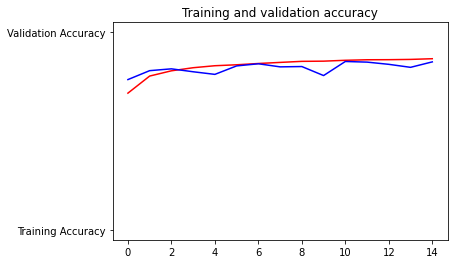

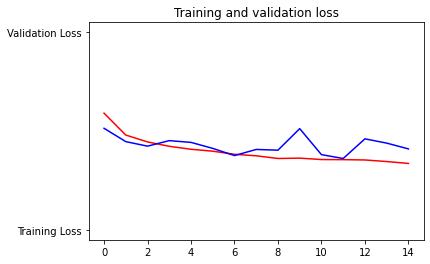

In [18]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

## In this codeblock you should be able to upload an image here and have it classified without crashing.

In [20]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150,150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Using TensorFlow backend.


Saving large.jpg to large.jpg
[0.]
large.jpg is a cat
